# Frequência e Exclusividade do Termo (TF-IDF)
Este estudo propõe a contrução do cálculo de `TF-IDF` manualmente a fim de entender todo o processo que o compõe.

Mas o que diabos é `TF-IDF`?<br>
`TF-IDF` é uma `estatística` que faz alusão a `identificação de palavras chave em um texto`. Em termos mais técnicos, o TF-IDF evidenciará as palavras `mais utilizadas em um texto` ao mesmo tempo que `reforça` a relevância das palavras que são `pouco utilizadas em outros textos`.

Tome como exemplo a música Anunciação de Alceu Valença. Apesar do nome tão forte e distinto, ele não está na letra da música. Por isso vamos sempre lembrar da música da música pelos termos `TU` e `VENS`! 

É isso que vamos tentar abordar neste estudo. Tentar entender o quão exclusivo alguns termos são a cada música e tentar identificá-las desta forma.<br>
Para facilitar o entendimento vou usar algumas músicas populares e que você provávelmente já ouviu no seu streaming (ou no rádio).

# Instalações

In [1]:
#pip install wordcloud

# Imports

In [1]:
import pandas as pd
import numpy as np
import os

#import collections

from sklearn.feature_extraction.text import TfidfVectorizer
import math

import nltk
nltk.download('stopwords')

_stopwords = nltk.corpus.stopwords.words('portuguese')

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fernando/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Músicas
Lista somente os arquivos das músicas no diretório `dados`

In [4]:
_arquivos_musicas = [_arq for _arq in os.listdir("dados/") if str(_arq).endswith(".txt")]

In [5]:
_arquivos_musicas

['samurai.txt',
 'amor-e-sexo.txt',
 'morena-tropicana.txt',
 'anunciacao.txt',
 'sabia.txt']

# Leitura e tratamento das letras das músicas
Junta todas as linhas em `uma só string`, remove os `pulos de linha`, coloca tudo em `letra minúscula` e cria um `array de palavras`.

In [16]:
def _f_cleansing_letra_musica(
    _p_letra: list
) -> str:
    
    _termos = {
        "\n": "",
        "\t": " ",
        "(": "",
        ")": "",
        ",": ""
    }
    
    _letra = " ".join(_p_letra).lower()
    
    for _termo, _substituto in _termos.items():
        _letra = _letra.replace(
            _termo, _substituto
        )
    
    return _letra.split(" ")

In [17]:
_musicas = []

for _arquivo_musica in _arquivos_musicas:
    with open("dados/" + _arquivo_musica) as _o_arquivo_musica:
        _musicas.append({
            "musica": _arquivo_musica.replace(".txt", "").replace("-", " "),
            "letra": _f_cleansing_letra_musica(_o_arquivo_musica.readlines())
        })

_df_musicas = pd.DataFrame(_musicas)
_df_musicas

,musica,letra
0,samurai,"[ai, quanto, querer, cabe, em, meu, coração, a..."
1,amor e sexo,"[amor, é, um, livro, sexo, é, esporte, sexo, é..."
2,morena tropicana,"[da, manga, rosa, quero, o, gosto, e, o, sumo,..."
3,anunciacao,"[na, bruma, leve, das, paixões, que, vêm, de, ..."
4,sabia,"[a, todo, mundo, eu, dou, psiu, psiu, psiu, ps..."


# Saco de Palavras (BAG OF WORDS)
No primeiro bloco criamos um `bag of words global`, onde teremos uma `lista de palavras distinstas` contidas em todas as letras `conhecidas`.

Já no segundo bloco criamos uma `bag of words` para `cada música`.

No terceiro bloco criamos um `DataFrame` com a `explosão de cada termo em uma linha` para facilitar `análises futuras`.

No quarto bloco temos um `DataFrame` por termo e em quais músicas ele aparece.

In [18]:
_bag_of_words = sorted(list(set(
    [_palavra for _letra in _df_musicas["letra"].values.flatten() for _palavra in _letra]
)))
" ".join(_bag_of_words)

" a afaga ah ai alivia amizade amor anda animal anjo antes anuncio ao aos aquilo as assim atrai beijo bem bom bossa brincar bruma cabe cabelo caiana caju cajá caldo cana carnaval carne casa catedrais cavalo caí chegando cinema coisa contra coração crescei cristão cá d'eu da dar das de demora dentro depois desfrutar divino diz dizem dizer do doce dois domingo dor dos dou duvido e em embora epiléticos escolha escuto esporte eu fala fantasia favor faz feliz fere fruta fundas gosto hum iluminar imaginação invasão isso iô jaboticaba juá já latifúndio leve linda livro luar lutar macia maduro manga manhã mas mata me mel melão meu minha morena mundo na no nos nossas noturno nova novela nu numa não nós o oh olhar onde os outros ouvido pagão paixão paixões para passarinhos patéticos peito pele pelo pena pensamento perguntando poder poesia por pra praga prosa psiu pés quando quanto quarando que quer querer quero quintal quis rosa roupas sabiá sabor sai saliva samurai sapoti se selva sem sempre se

In [19]:
_df_musicas["bag_of_words"] = _df_musicas["letra"].apply(
    lambda _letra:
        list(set(_letra))
)

_df_musicas.head()

,musica,letra,bag_of_words
0,samurai,"[ai, quanto, querer, cabe, em, meu, coração, a...","[sem, querer, iluminar, sofrer, meu, ser, sai,..."
1,amor e sexo,"[amor, é, um, livro, sexo, é, esporte, sexo, é...","[, cinema, sem, é, escolha, fantasia, outros, ..."
2,morena tropicana,"[da, manga, rosa, quero, o, gosto, e, o, sumo,...","[umbu, é, jaboticaba, saliva, caldo, ô, caju, ..."
3,anunciacao,"[na, bruma, leve, das, paixões, que, vêm, de, ...","[duvido, teus, ah, sussurrou, meu, nossas, pai..."
4,sabia,"[a, todo, mundo, eu, dou, psiu, psiu, psiu, ps...","[passarinhos, alivia, perguntando, meu, sabiá,..."


In [20]:
_dict_musica_baf_of_words = _df_musicas[["musica", "bag_of_words"]].to_dict()
_dict_musicas = _dict_musica_baf_of_words["musica"]
_dict_bag_of_words = _dict_musica_baf_of_words["bag_of_words"]

_df_musicas_termos = pd.DataFrame([{"musica": _nome_musica, "termo": _termo} for _key_musica, _nome_musica in _dict_musicas.items() for _termo in _dict_bag_of_words[_key_musica]])
_df_musicas_termos.head()

,musica,termo
0,samurai,sem
1,samurai,querer
2,samurai,iluminar
3,samurai,sofrer
4,samurai,meu


In [21]:
_df_musicas_termos["musicas"] = _df_musicas_termos.groupby(['termo'])['musica'].transform(lambda _musica: ', '.join(_musica))

_df_termos_musicas = _df_musicas_termos[[
    "termo",
    "musicas"
]].drop_duplicates()

_df_termos_musicas.head()

,termo,musicas
0,sem,"samurai, amor e sexo"
1,querer,samurai
2,iluminar,samurai
3,sofrer,samurai
4,meu,"samurai, anunciacao, sabia"


# Frequência das Palavras por Música (NUM OF WORDS)
Abaixo temos uma `função` que ajudará a criar uma `Bag of Words` com as frequências de cada palavra em `cada letra` de música, usando o `layout` de `Bag of Words` criado com `todas as palavras de todas as músicas`.

In [22]:
def _f_gera_bag_of_words_letra(
    _p_bag_of_words: list,
    _p_letra: list
) -> dict:
    _bag_of_words_letra = dict.fromkeys(_p_bag_of_words, 0)
    
    for _palavra in _p_letra:
        _bag_of_words_letra[_palavra] += 1
    
    return _bag_of_words_letra

In [23]:
_df_musicas["freq_palavras"] = _df_musicas["letra"].apply(
    lambda _letra: _f_gera_bag_of_words_letra(
        _bag_of_words,
        _letra
    )
)

_df_musicas

,musica,letra,bag_of_words,freq_palavras
0,samurai,"[ai, quanto, querer, cabe, em, meu, coração, a...","[sem, querer, iluminar, sofrer, meu, ser, sai,...","{'': 0, 'a': 2, 'afaga': 2, 'ah': 0, 'ai': 4, ..."
1,amor e sexo,"[amor, é, um, livro, sexo, é, esporte, sexo, é...","[, cinema, sem, é, escolha, fantasia, outros, ...","{'': 12, 'a': 0, 'afaga': 0, 'ah': 0, 'ai': 1,..."
2,morena tropicana,"[da, manga, rosa, quero, o, gosto, e, o, sumo,...","[umbu, é, jaboticaba, saliva, caldo, ô, caju, ...","{'': 0, 'a': 0, 'afaga': 0, 'ah': 0, 'ai': 36,..."
3,anunciacao,"[na, bruma, leve, das, paixões, que, vêm, de, ...","[duvido, teus, ah, sussurrou, meu, nossas, pai...","{'': 0, 'a': 2, 'afaga': 0, 'ah': 60, 'ai': 0,..."
4,sabia,"[a, todo, mundo, eu, dou, psiu, psiu, psiu, ps...","[passarinhos, alivia, perguntando, meu, sabiá,...","{'': 0, 'a': 8, 'afaga': 0, 'ah': 0, 'ai': 0, ..."


# Term Frequency (TF)
Esta técnica permite avaliar o `quanto cada palavra repete dentro de uma letra`. Ou seja, o quanto esta palavra `pode`, eu digo `pode`, ser `importante` para a `letra da música`.

In [24]:
def _f_tf(
    _p_freq_palavras: dict, #numOfWords
    _p_letra: list          #bagOfWords
) -> dict:
    _tf = {}
    _len = len(_p_letra) #bagOfWordsCount
    
    for _palavra, _frequencia in _p_freq_palavras.items():
        _tf[_palavra] = _frequencia / float(_len)
    
    return _tf

In [25]:
_df_musicas["tf"] = _df_musicas.apply(
    lambda _musica:
        _f_tf(
            _musica["freq_palavras"],
            _musica["bag_of_words"]
        ), axis=1
)

_df_musicas

,musica,letra,bag_of_words,freq_palavras,tf
0,samurai,"[ai, quanto, querer, cabe, em, meu, coração, a...","[sem, querer, iluminar, sofrer, meu, ser, sai,...","{'': 0, 'a': 2, 'afaga': 2, 'ah': 0, 'ai': 4, ...","{'': 0.0, 'a': 0.03225806451612903, 'afaga': 0..."
1,amor e sexo,"[amor, é, um, livro, sexo, é, esporte, sexo, é...","[, cinema, sem, é, escolha, fantasia, outros, ...","{'': 12, 'a': 0, 'afaga': 0, 'ah': 0, 'ai': 1,...","{'': 0.1935483870967742, 'a': 0.0, 'afaga': 0...."
2,morena tropicana,"[da, manga, rosa, quero, o, gosto, e, o, sumo,...","[umbu, é, jaboticaba, saliva, caldo, ô, caju, ...","{'': 0, 'a': 0, 'afaga': 0, 'ah': 0, 'ai': 36,...","{'': 0.0, 'a': 0.0, 'afaga': 0.0, 'ah': 0.0, '..."
3,anunciacao,"[na, bruma, leve, das, paixões, que, vêm, de, ...","[duvido, teus, ah, sussurrou, meu, nossas, pai...","{'': 0, 'a': 2, 'afaga': 0, 'ah': 60, 'ai': 0,...","{'': 0.0, 'a': 0.03636363636363636, 'afaga': 0..."
4,sabia,"[a, todo, mundo, eu, dou, psiu, psiu, psiu, ps...","[passarinhos, alivia, perguntando, meu, sabiá,...","{'': 0, 'a': 8, 'afaga': 0, 'ah': 0, 'ai': 0, ...","{'': 0.0, 'a': 0.19047619047619047, 'afaga': 0..."


# Inverse Data Frequency (IDF)
Agora vamos aplicar uma técnica que verifica `o quanto a palavra é exclusiva` dentre `todas as letras de músicas`. Ou seja, o quão `rara` é a palavra.

In [26]:
def _f_idf(
    _p_freq_palavras_musicas: pd.Series
):
    _n = len(_p_freq_palavras_musicas)
    
    _freq_palavras_global = dict.fromkeys(_p_freq_palavras_musicas[0].keys(), 0)
    
    for _freq_palavras_musica in _p_freq_palavras_musicas:
        for _palavra, _freq in _freq_palavras_musica.items():
            if _freq > 0:
                _freq_palavras_global[_palavra] += 1
    
    for _palavra, _freq in _freq_palavras_global.items():
        _freq_palavras_global[_palavra] = math.log(_n / float(_freq))
    
    return _freq_palavras_global

In [27]:
_idf = _f_idf(_df_musicas["freq_palavras"])

# TF-IDF
O índice `TF-IDF` por fim é calculado `multiplicando-se` o coeficiente de `TF de cada palavra` em cada música em relação ao coeficiente `IDF` dessa `palavra`.

In [28]:
def _f_tf_idf(
    _p_tf: dict,
    _p_idf: dict
):
    _tf_idf = {}
    for _palavra, _freq in _p_tf.items():
        _tf_idf[_palavra] = _freq * _p_idf[_palavra]
    
    return _tf_idf

In [29]:
_df_musicas["tf_idf"] = _df_musicas["tf"].apply(
    lambda _tf: 
        _f_tf_idf(
            _tf,
            _idf
        )
)

_df_musicas

,musica,letra,bag_of_words,freq_palavras,tf,tf_idf
0,samurai,"[ai, quanto, querer, cabe, em, meu, coração, a...","[sem, querer, iluminar, sofrer, meu, ser, sai,...","{'': 0, 'a': 2, 'afaga': 2, 'ah': 0, 'ai': 4, ...","{'': 0.0, 'a': 0.03225806451612903, 'afaga': 0...","{'': 0.0, 'a': 0.016478245927935183, 'afaga': ..."
1,amor e sexo,"[amor, é, um, livro, sexo, é, esporte, sexo, é...","[, cinema, sem, é, escolha, fantasia, outros, ...","{'': 12, 'a': 0, 'afaga': 0, 'ah': 0, 'ai': 1,...","{'': 0.1935483870967742, 'a': 0.0, 'afaga': 0....","{'': 0.3115041120840194, 'a': 0.0, 'afaga': 0...."
2,morena tropicana,"[da, manga, rosa, quero, o, gosto, e, o, sumo,...","[umbu, é, jaboticaba, saliva, caldo, ô, caju, ...","{'': 0, 'a': 0, 'afaga': 0, 'ah': 0, 'ai': 36,...","{'': 0.0, 'a': 0.0, 'afaga': 0.0, 'ah': 0.0, '...","{'': 0.0, 'a': 0.0, 'afaga': 0.0, 'ah': 0.0, '..."
3,anunciacao,"[na, bruma, leve, das, paixões, que, vêm, de, ...","[duvido, teus, ah, sussurrou, meu, nossas, pai...","{'': 0, 'a': 2, 'afaga': 0, 'ah': 60, 'ai': 0,...","{'': 0.0, 'a': 0.03636363636363636, 'afaga': 0...","{'': 0.0, 'a': 0.018575477227854208, 'afaga': ..."
4,sabia,"[a, todo, mundo, eu, dou, psiu, psiu, psiu, ps...","[passarinhos, alivia, perguntando, meu, sabiá,...","{'': 0, 'a': 8, 'afaga': 0, 'ah': 0, 'ai': 0, ...","{'': 0.0, 'a': 0.19047619047619047, 'afaga': 0...","{'': 0.0, 'a': 0.09730011881256966, 'afaga': 0..."


# Análise dos Resultados
Neste ponto toda a parte de coeficientes já está pronta. Nos resta observar os resultados e tirar as conclusões.

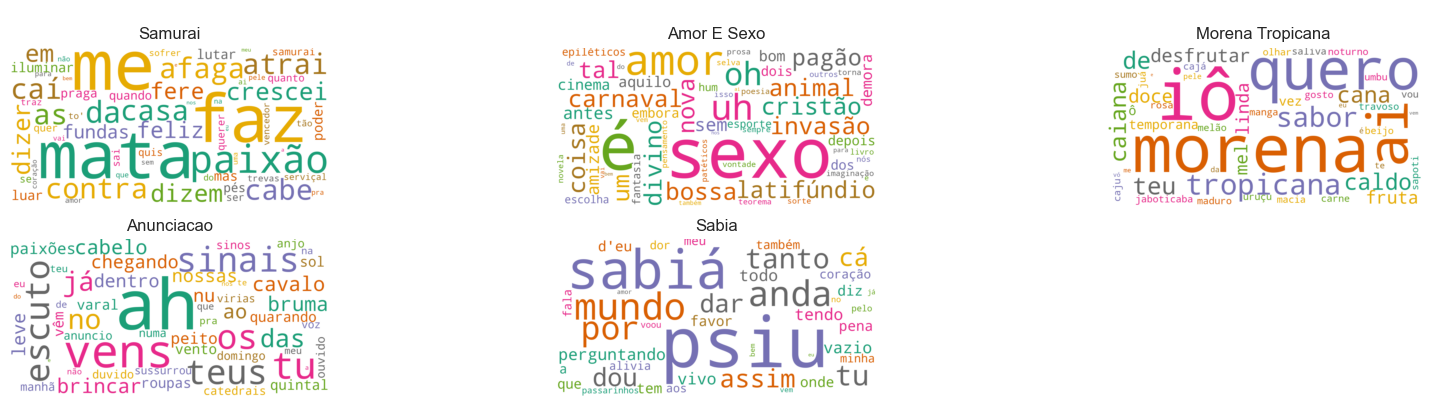

In [30]:
sns.set()
plt.rcParams['figure.figsize'] = [20, 12]
#plt.rcParams['axes.facecolor'] = 'silver'

_musicas_tf_idf = _df_musicas.set_index('musica')["tf_idf"].to_dict()

_wc_musicas_tf_idf = wordcloud.WordCloud(
    width=1600,
    height=800,
    background_color="white", 
    #mask=mask, 
    contour_width=0.1, 
    contour_color="lightgrey", 
    max_font_size=350, 
    max_words=100,
    random_state=42,
    colormap="Dark2"
)

for _i, _musica_tf_idf in enumerate(_musicas_tf_idf.items()):
    rgb_color = [0,0,0] #color in RGB format
    rgb_decimal_1 = [x / 255.0 for x in rgb_color]
    
    #params = {'text.color':'black', 'xtick.color':'black', 'ytick.color':'black', 'axes.facecolor': rgb_decimal_1} 
    #plt.rcParams.update(params)
    
    _musica = _musica_tf_idf[0]
    _tf_idf = _musica_tf_idf[1]
    
    _wc_musicas_tf_idf.generate_from_frequencies(_tf_idf)   
    plt.subplot(len(_musicas_tf_idf), 3, _i+1)
    plt.imshow(_wc_musicas_tf_idf, interpolation="bilinear")
    
    plt.axis("off")
    plt.title("\n" + _musica.title())
    
plt.show()

# Palavras mais Relevantes (IDF)
Abaixo uma nuvem de palavras construída a partir do coeficiente IDF de cada palavra. Nota-se que as palavras com início "P" são majoritariamente as palavras chave nas músicas. (risos)

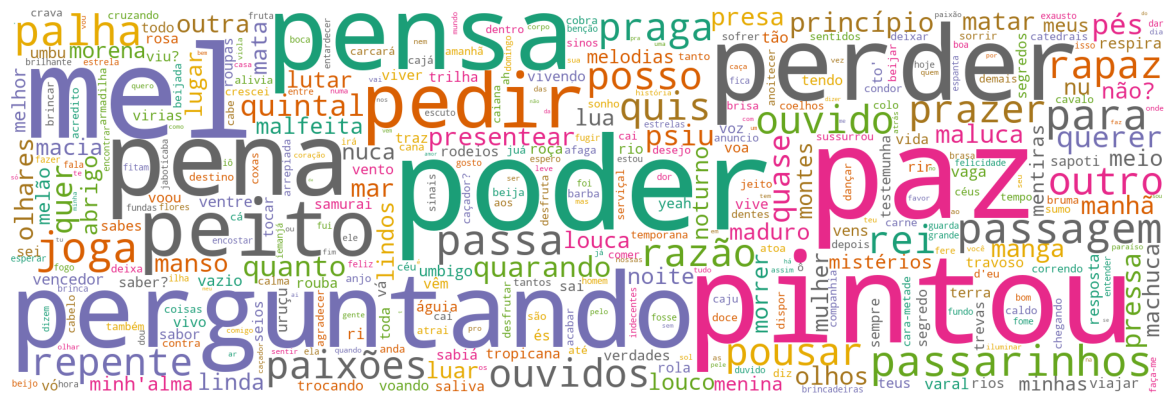

In [ ]:
sns.set()
plt.rcParams['figure.figsize'] = [20, 5]

_wc_idf = wordcloud.WordCloud(
    width=1800, height=600,
    background_color="white",
    max_font_size=200, 
    max_words=500,
    random_state=1,
    colormap="Dark2"
)

_wc_idf.generate_from_frequencies(_df_idf.sort_values(by=["idf"], ascending=False).set_index(["termo"]).to_dict()["idf"]) 

plt.imshow(_wc_idf)
plt.axis("off")
plt.show()

# Conclusão
Como podemos observar o TF-IDF tem uma boa aderência no uso de identificação de palavras que nos fazem lembrar da música.

Vamos analisar alguns casos:<br>
Vejamos a música `Morena Tropicana`. Os termos de maior relevância foram `IÔ, AI, MORENA, TROPICANA e SABOR`, que são os termos que compõem o refrão da música.<br>
Já na música `Sabiá` os termos de maior relevância foram `PSIU, SABIÁ, ANDA e MUNDO`, que se repetem por toda a música.

Abaixo faço um aprofundamento maior na música `Anunciação`.

## Anunciação, Alceu Valença

In [ ]:
_df_tf_musica = pd.DataFrame(_df_musicas[
    (_df_musicas.musica=="anunciacao")
]["freq_palavras"].values[0].items(), columns=["termo", "tf"])

_df_tf_musica = _df_tf_musica[
    (_df_tf_musica.tf > 0)
]

_musica_tf_idf = _df_musicas[
    (_df_musicas.musica == "anunciacao")
].tf_idf.values[0]

_df_musica_tf_idf = pd.DataFrame(_musica_tf_idf.items(), columns=["termo", "tf_idf"])

_df_musica_analise =_df_tf_musica.set_index(["termo"]).join(_df_idf.set_index(["termo"])).join(_df_termos_musicas.set_index(["termo"])).join(_df_musica_tf_idf.set_index(["termo"])).reset_index()

_df_musica_analise["tf_idf"] = _df_musica_analise["tf_idf"].round(2)
_df_musica_analise["idf"] = _df_musica_analise["idf"].round(2)

### Palavras mais Relevantes da Música Anunciação, Alceu Valença

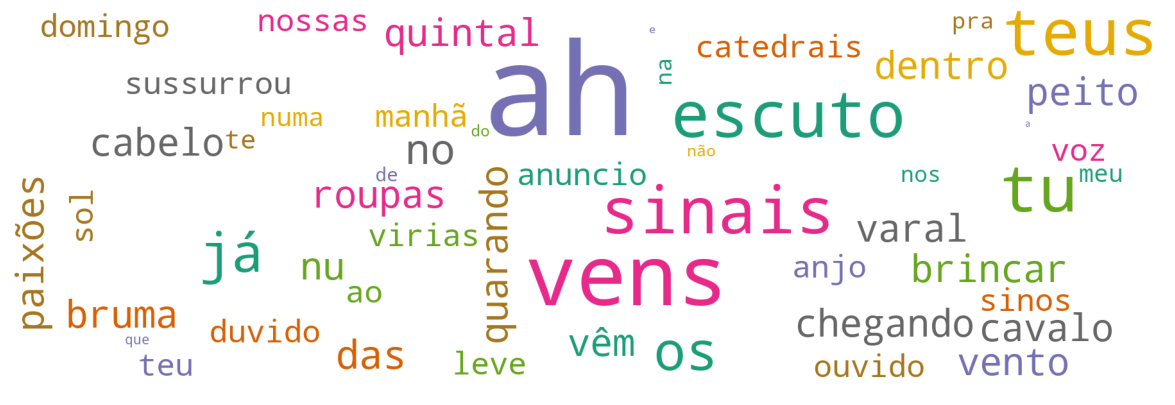

In [ ]:
sns.set()
plt.rcParams['figure.figsize'] = [20, 5]

_wc_idf = wordcloud.WordCloud(
    width=1800, height=600,
    background_color="white",
    max_font_size=200, 
    max_words=500,
    random_state=1,
    colormap="Dark2"
)

_wc_idf.generate_from_frequencies(_musica_tf_idf) 

plt.imshow(_wc_idf)
plt.axis("off")
plt.show()

### Visão geral dos termos da música Anunciação, Alceu Valença
O termo `AH` é extremamente inflacionado e acaba atenuando a relevância de outros termos exclusivos desta musica, mas que são pouco repetidos como: `VENS`, `BRUMA`, `VARAL`, `SINAIS` etc.

In [ ]:
_df_musica_analise.sort_values(by=["tf_idf"], ascending=False).head(25)

,termo,tf,idf,musicas,tf_idf
1,ah,60,2.08,anunciacao,2.27
50,vens,19,2.08,anunciacao,0.72
41,sinais,10,2.08,anunciacao,0.38
18,escuto,10,2.08,anunciacao,0.38
47,teus,10,2.08,anunciacao,0.38
48,tu,21,0.98,"anunciacao, sabia, caca cacador angra",0.37
20,já,10,1.39,"anunciacao, sabia",0.25
32,os,10,1.39,"o meu amor, anunciacao",0.25
25,no,11,0.69,"anunciacao, sabia, caca cacador angra, meu abrigo",0.14
11,das,5,1.39,"anunciacao, meu abrigo",0.13


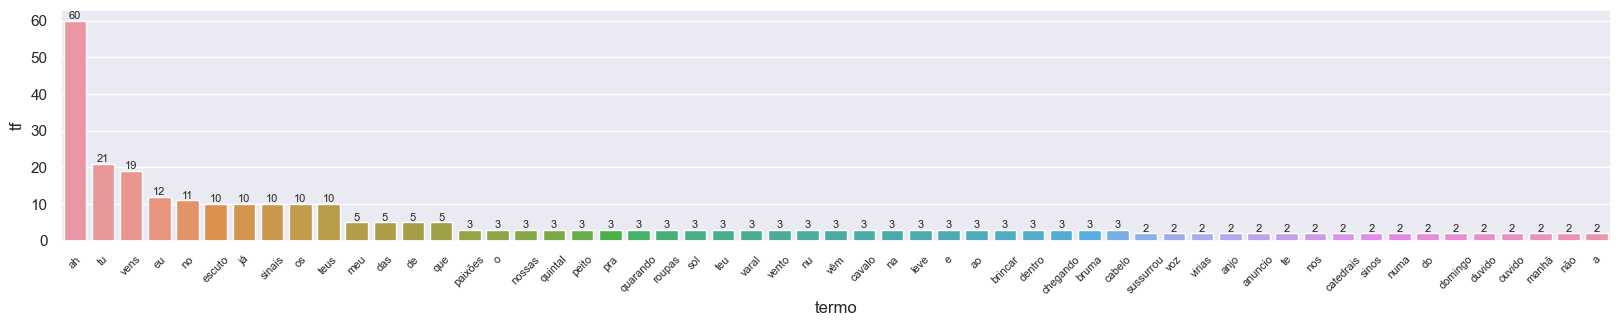

In [ ]:
sns.set(rc={'figure.figsize':(20,3)})
ax = sns.barplot(data=_df_musica_analise.sort_values(by=["tf"], ascending=False), x="termo", y="tf", orient="v")
abc = plt.xticks(fontsize=8, rotation=45)
abc = ax.bar_label(ax.containers[0], fontsize=8)

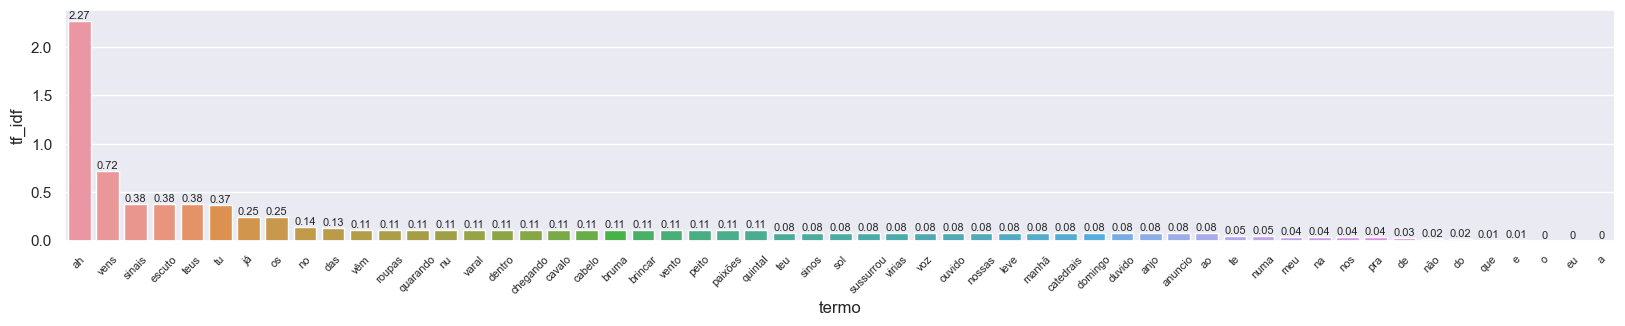

In [ ]:
sns.set(rc={'figure.figsize':(20,3)})
ax = sns.barplot(data=_df_musica_analise.sort_values(by=["tf_idf"], ascending=False), x="termo", y="tf_idf", orient="v")
abc = plt.xticks(fontsize=8, rotation=45)
abc = ax.bar_label(ax.containers[0], fontsize=8)